# Finetune VGG16


With 1000 x 400 melspectrogram images without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
FINETUNED_MODEL = 'vgg16'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'

Custom dataset class for loading the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.vgg16(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.classifier[-1].parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [14]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for VGG16
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

epochs = 25

Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.78it/s, Loss=1.9963641166687012, Elapsed=26.7022s, ETA=0.0000s] 


Epoch 1 completed in 105.9797s
Train Loss: 1.42773145712869 - Train Accuracy: 43.651206440379006
Validation Loss: 1.2636817868550618 - Validation Accuracy: 51.99451245251161

Epoch 2/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.76it/s, Loss=1.603653907775879, Elapsed=26.8581s, ETA=0.0000s]  


Epoch 2 completed in 104.1491s
Train Loss: 1.3436698975590613 - Train Accuracy: 47.02064629926957
Validation Loss: 1.2374080514907837 - Validation Accuracy: 51.74124102997045

Epoch 3/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.80it/s, Loss=1.8995915651321411, Elapsed=26.8458s, ETA=0.0000s] 


Epoch 3 completed in 103.9063s
Train Loss: 1.324184309884992 - Train Accuracy: 47.26261278578051
Validation Loss: 1.2121578741073609 - Validation Accuracy: 53.398058252427184

Epoch 4/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.91it/s, Loss=1.6346721649169922, Elapsed=26.2386s, ETA=0.0000s] 


Epoch 4 completed in 103.7575s
Train Loss: 1.3175660902365094 - Train Accuracy: 48.20786504149612
Validation Loss: 1.1998141161600748 - Validation Accuracy: 53.999577880962434

Epoch 5/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.86it/s, Loss=1.790893316268921, Elapsed=27.1164s, ETA=0.0000s]   


Epoch 5 completed in 104.2396s
Train Loss: 1.3153807906746176 - Train Accuracy: 47.981728138214876
Validation Loss: 1.2269383589426677 - Validation Accuracy: 51.45631067961165

Epoch 6/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.90it/s, Loss=1.6968525648117065, Elapsed=26.6908s, ETA=0.0000s] 


Epoch 6 completed in 104.8833s
Train Loss: 1.3167799955847634 - Train Accuracy: 48.119671649216436
Validation Loss: 1.202035093307495 - Validation Accuracy: 54.010130856901654

Epoch 7/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.90it/s, Loss=1.6872444152832031, Elapsed=26.4375s, ETA=0.0000s] 


Epoch 7 completed in 104.2354s
Train Loss: 1.3119825489948251 - Train Accuracy: 48.35033129056331
Validation Loss: 1.1903262996673585 - Validation Accuracy: 54.1895314478683

Epoch 8/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.87it/s, Loss=1.8118114471435547, Elapsed=26.7233s, ETA=0.0000s] 


Epoch 8 completed in 104.1816s
Train Loss: 1.3035319402727779 - Train Accuracy: 48.567422717713306
Validation Loss: 1.2073387893040974 - Validation Accuracy: 53.640776699029125

Epoch 9/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.88it/s, Loss=1.675278663635254, Elapsed=26.6382s, ETA=0.0000s]  


Epoch 9 completed in 104.5039s
Train Loss: 1.3101565748280872 - Train Accuracy: 48.17846724406956
Validation Loss: 1.1763727951049805 - Validation Accuracy: 54.91768678767413

Epoch 10/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.88it/s, Loss=1.8983542919158936, Elapsed=26.6350s, ETA=0.0000s] 


Epoch 10 completed in 104.1926s
Train Loss: 1.3031962045355339 - Train Accuracy: 48.56516134868049
Validation Loss: 1.2007469193140665 - Validation Accuracy: 53.09202195018995

Epoch 11/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.86it/s, Loss=1.9550511837005615, Elapsed=26.4652s, ETA=0.0000s] 


Epoch 11 completed in 104.0952s
Train Loss: 1.3086994714130555 - Train Accuracy: 48.32319486216956
Validation Loss: 1.193532058397929 - Validation Accuracy: 54.28450823132124

Epoch 12/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.88it/s, Loss=1.6782389879226685, Elapsed=26.6652s, ETA=0.0000s] 


Epoch 12 completed in 104.0938s
Train Loss: 1.308834533126368 - Train Accuracy: 48.24630831505393
Validation Loss: 1.1835550530751546 - Validation Accuracy: 54.56943858168003

Epoch 13/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.90it/s, Loss=1.4954512119293213, Elapsed=26.6899s, ETA=0.0000s] 


Epoch 13 completed in 104.3398s
Train Loss: 1.3080458713404706 - Train Accuracy: 48.40686551638362
Validation Loss: 1.1783657058080037 - Validation Accuracy: 54.20008442380752

Epoch 14/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.83it/s, Loss=1.7673026323318481, Elapsed=26.7487s, ETA=0.0000s] 


Epoch 14 completed in 104.1907s
Train Loss: 1.3037457462680133 - Train Accuracy: 48.705366228714865
Validation Loss: 1.1943104902903239 - Validation Accuracy: 54.43224989447024

Epoch 15/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.87it/s, Loss=1.4789087772369385, Elapsed=26.6698s, ETA=0.0000s] 


Epoch 15 completed in 104.2042s
Train Loss: 1.3098347531577754 - Train Accuracy: 48.49958164672893
Validation Loss: 1.1849582878748577 - Validation Accuracy: 54.485014774166316

Epoch 16/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.93it/s, Loss=1.7435780763626099, Elapsed=26.7160s, ETA=0.0000s] 


Epoch 16 completed in 104.3241s
Train Loss: 1.3118058319036672 - Train Accuracy: 48.48149069446643
Validation Loss: 1.184848608970642 - Validation Accuracy: 54.78049810046433

Epoch 17/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.83it/s, Loss=1.538386583328247, Elapsed=26.7488s, ETA=0.0000s]  


Epoch 17 completed in 104.3855s
Train Loss: 1.3078727684269063 - Train Accuracy: 48.750593609371116
Validation Loss: 1.1751679722468058 - Validation Accuracy: 54.6855213170114

Epoch 18/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.83it/s, Loss=1.5683987140655518, Elapsed=26.6913s, ETA=0.0000s] 


Epoch 18 completed in 104.0779s
Train Loss: 1.2979482794772683 - Train Accuracy: 48.95411682232423
Validation Loss: 1.1692908239364623 - Validation Accuracy: 55.50865344027016

Epoch 19/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.91it/s, Loss=1.94035005569458, Elapsed=26.5923s, ETA=0.0000s]   


Epoch 19 completed in 104.2365s
Train Loss: 1.3080685745084906 - Train Accuracy: 48.51993396802424
Validation Loss: 1.1927610095342 - Validation Accuracy: 54.26340227944281

Epoch 20/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.80it/s, Loss=1.4594731330871582, Elapsed=26.9108s, ETA=0.0000s] 


Epoch 20 completed in 104.5998s
Train Loss: 1.3073643087651687 - Train Accuracy: 48.70310485968205
Validation Loss: 1.168318521976471 - Validation Accuracy: 55.287040945546636

Epoch 21/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.82it/s, Loss=1.399672031402588, Elapsed=26.5426s, ETA=0.0000s]  


Epoch 21 completed in 103.9605s
Train Loss: 1.3113965161273935 - Train Accuracy: 48.54028628931955
Validation Loss: 1.1669855435689291 - Validation Accuracy: 55.39257070493879

Epoch 22/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.85it/s, Loss=1.5132277011871338, Elapsed=26.8293s, ETA=0.0000s] 


Epoch 22 completed in 104.1740s
Train Loss: 1.3064907889145647 - Train Accuracy: 48.73250265710861
Validation Loss: 1.1835631616910298 - Validation Accuracy: 54.3372731110173

Epoch 23/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.91it/s, Loss=1.8100554943084717, Elapsed=26.4863s, ETA=0.0000s] 


Epoch 23 completed in 104.1192s
Train Loss: 1.3051729743191272 - Train Accuracy: 48.660138848058615
Validation Loss: 1.1805354166030884 - Validation Accuracy: 54.72773322076826

Epoch 24/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.70it/s, Loss=1.801924467086792, Elapsed=27.6343s, ETA=0.0000s]   


Epoch 24 completed in 106.6115s
Train Loss: 1.3036715708716067 - Train Accuracy: 48.68501390741955
Validation Loss: 1.1802252531051636 - Validation Accuracy: 54.31616715913887

Epoch 25/25


Validating: 100%|██████████| 75/75 [00:16<00:00,  4.58it/s, Loss=1.6132583618164062, Elapsed=29.3591s, ETA=0.0000s]  


Epoch 25 completed in 109.1358s
Train Loss: 1.3095728754997253 - Train Accuracy: 48.5493317654508
Validation Loss: 1.1766679922739665 - Validation Accuracy: 54.938792739552554



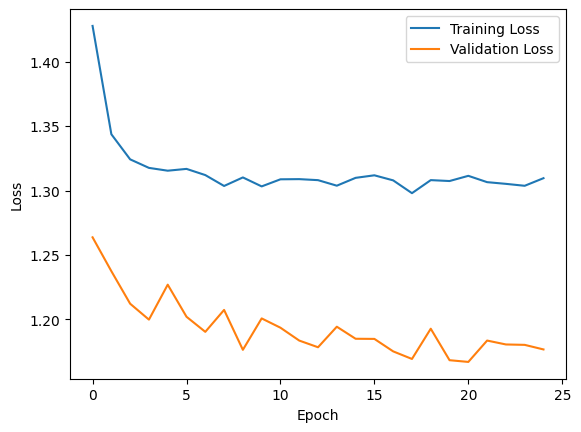

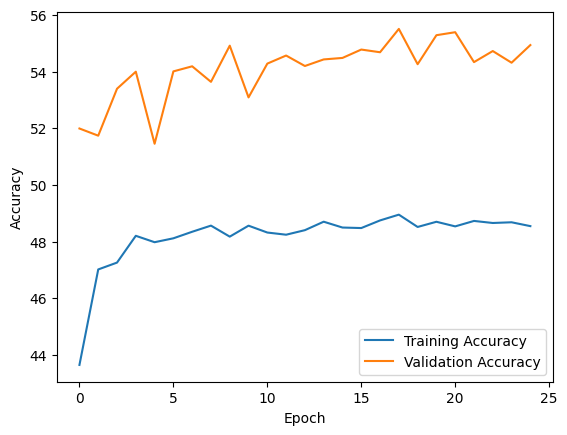

In [15]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate the best model on the test set


In [17]:
def load_and_evaluate_best_model(model, testloader, criterion, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    running_loss = 0.0
    correct = 0
    total = 0

    print("Evaluating best model on test set...")
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate final metrics
    test_loss = running_loss / len(testloader)
    test_accuracy = 100 * correct / total

    print(f"\nTest Results (Best Model):")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy, all_preds, all_labels

Evaluate the best model on the test set


C:\Users\profi\AppData\Local\Temp\ipykernel_1916\3579996063.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:29<00:00,  2.51it/s]



Test Results (Best Model):
Test Loss: 1.1507
Test Accuracy: 55.34%


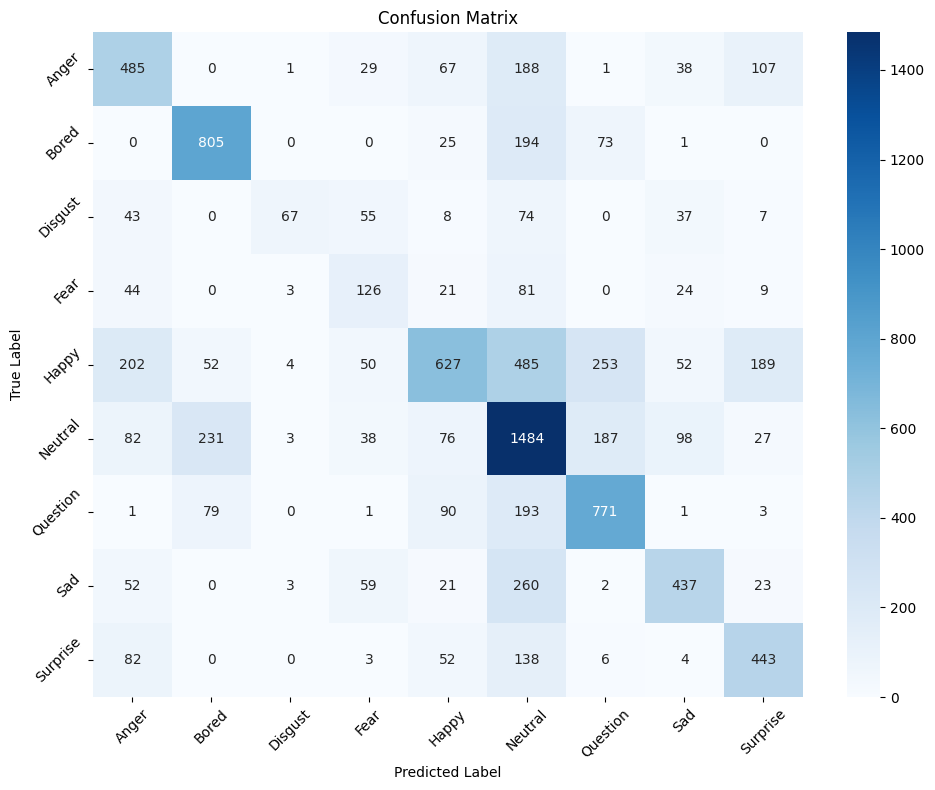

In [18]:
# Load and evaluate the best model
best_model_path = f'best_{FINETUNED_MODEL}.pt'
test_loss, test_accuracy, all_preds, all_labels = load_and_evaluate_best_model(
    model=model,
    testloader=testloader,
    criterion=criterion,
    device=device,
    model_path=best_model_path
)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)